# Code for calculating beam emmitance using Pepperpot device by typical rms method, new FFT using method and comparison between the two 

## Necessary Python packages.

In [424]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import ipywidgets
from scipy.fft import fft, fftfreq,ifft
from scipy.signal import argrelextrema
from sklearn.linear_model import LinearRegression
import time
import sys

## Loading already processed Pepperpot image data.

In [425]:
df = pd.read_csv("Results/Results_final.csv")

In [426]:
df

,,Label,Area,Mean,Min,Max,X,Y,XM,YM,Perim.,Major,Minor,Angle,IntDen,RawIntDen
0,1,pperpot_6K-2.tif:0001-0015,0.060573,17788.000000,10240,28202,8.112939,12.118141,8.113629,12.117228,0.960936,0.312522,0.246779,141.858252,1077.471794,6421468
1,2,pperpot_6K-2.tif:0002-0015,0.132052,26488.404066,12850,42710,8.166679,0.173604,8.166634,0.172610,1.380431,0.460020,0.365494,176.031102,3497.857499,20846374
2,3,pperpot_6K-2.tif:0003-0017,0.124837,24723.997312,11225,39577,8.713135,0.193414,8.710933,0.192225,1.383574,0.417102,0.381077,121.360795,3086.478178,18394654
3,4,pperpot_6K-2.tif:0004-0053,0.115777,25306.771014,14571,37449,8.703223,0.700501,8.702714,0.700380,1.283090,0.420540,0.350529,84.332441,2929.931141,17461672
4,5,pperpot_6K-2.tif:0005-0053,0.146147,25540.195178,10286,45056,9.263129,0.689545,9.262096,0.692269,1.430943,0.440285,0.422635,117.289914,3732.621509,22245510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,386,pperpot_6K-2.tif:0386-0930,0.129703,29061.078913,12297,51192,4.872051,12.078766,4.874666,12.079468,1.365255,0.429151,0.384814,32.847987,3769.318319,22464214
386,387,pperpot_6K-2.tif:0387-0931,0.117119,27933.532951,15788,43451,5.966702,12.069618,5.966854,12.071516,1.276804,0.395361,0.377175,74.390376,3271.544843,19497606
387,388,pperpot_6K-2.tif:0388-0931,0.122656,27213.321477,11204,43008,6.495168,12.072191,6.495377,12.071525,1.281249,0.408008,0.382764,54.063681,3337.878442,19892938
388,389,pperpot_6K-2.tif:0389-0931,0.110575,24821.180577,13168,37659,7.046633,12.079790,7.046243,12.080622,1.255342,0.391491,0.359621,98.993634,2744.602384,16357158


## Find the center point of the beam: Get the spot with the least deviation from the sorrounding ones.
Taking into account that the *beam is diverging* we will suppose that the point with the least deviating neighbours will we the center point.
For each point we save the sumation of the 4 minimum distances from all the other points. We will consider that the center will be the spot whose sumation is the minimum. It must fulfill also that is inside a (Ax, Ay) bounds from the pyhiscal center.

In [427]:
# Define the (Ax, Ay) bounds (mm)
Ax = 1
Ay = 1

In [428]:
# Get the X and Y position arrays
x = df['X'].to_numpy()
y = df['Y'].to_numpy()

In [429]:
# First approximation of the center
cx = (np.max(x) + np.min(x))/2
cy = (np.max(y) + np.min(y))/2

In [430]:
# Get the 4 minimum distances and then the addition of them for each point
# 5 distances buffer. One is going to be 0, because it is the distance from 
# itself.
buffer4d = np.zeros((5))
buffer4dindex = []
mindists = np.zeros((x.shape))
mindistsindex = []
for i in range(len(x)):
    for j in range(len(x)):
       distcalc = np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
       if j < 5:
           buffer4d[j] = distcalc
           buffer4dindex.append((distcalc,j))
       else:
           buffer4d = np.sort(buffer4d)
           buffer4dindex = sorted(buffer4dindex, key=lambda x: x[0]) 
           if distcalc < buffer4d[4]:
               buffer4d[4] = distcalc
               buffer4dindex[4]= (distcalc,j)
               buffer4d = np.sort(buffer4d) # The last index must be sorted too
       
    mindists[i] = np.sum(buffer4d)
    mindistsindex.append(buffer4dindex)
    buffer4dindex = []
    i = i + 1
# Get the index of the the sumation of the 4 minimum distances from all the 
# other points.
centerindex = np.argmin(mindists) 
print("Center index: ", centerindex)
print("Center index indices: ", mindistsindex[centerindex])

Center index:  348
Center index indices:  [(0.0, 348), (0.4786656583169509, 347), (0.5226478679158645, 340), (0.5279095503597182, 351), (0.5424136167354218, 359)]


In [431]:
# Remove the minima that is not inside the (Ax, Ay) boundaries
while np.abs(x[centerindex]-cx)> Ax and np.abs(y[centerindex]-cy)> Ay:
    mindists = np.delete(mindists,centerindex)
    centerindex = list(mindists).index(min(mindists))
    
print("Center index: ", centerindex)
print("Center distance from pyhisical center: ", 
      x[centerindex]-cx, y[centerindex]-cy)
print("Center index neighbour indices: ", mindistsindex[centerindex])

Center index:  197
Center distance from pyhisical center:  -0.7472050000000001 0.008994500000000905
Center index neighbour indices:  [(0.0, 197), (0.5290561329017931, 198), (0.5381419025517339, 196), (0.5409161758738593, 212), (0.5636015288357553, 159)]


In [432]:
# Translate all points to the calculated center 
x = x - x[centerindex]
y = y - y[centerindex]

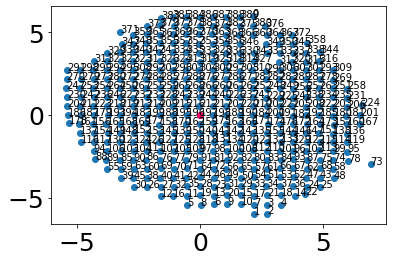

In [433]:
# Draw the points and highlight the center.
fig, ax = plt.subplots()
ax.scatter(x, y)

for i in range(len(x)):
    if i == centerindex:
        ax.scatter(x[i], y[i], color="#FF0066")
    ax.annotate(i, (x[i], y[i]))
    
plt.rcParams['figure.figsize'] = [9.5, 6.0]
#plt.figure(figsize=(32, 24), dpi=300)

## Generating Pepperpot mesh. It is asumed that the mesh is square.
For the purpose of calculating emmitance, the position of the beamlest is given by the positions of the Pepperpot device mesh. Such a mesh with the size and separation between holes of the real Pepperpot device is generated. The image is also scalated so the distance between points near the center(Amesh) is equal to the distance between holes of the real mesh (Aactualmesh)

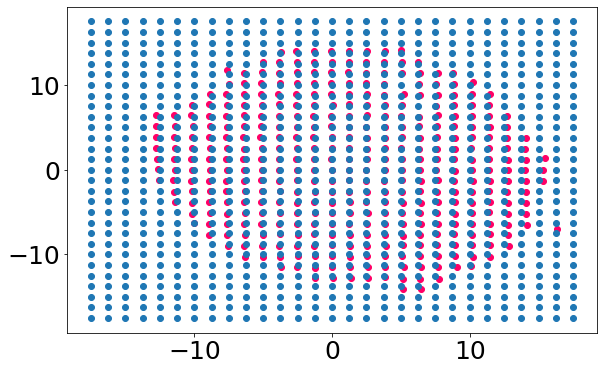

In [434]:
#Generates a square mesh with the physical dimensions of the device
def MeshGenerator(pointDis,MeshSize):
    pausux=pointDis
    pausuy=pointDis
    numx=round(MeshSize/pointDis)
    numy=round(MeshSize/pointDis)
    if(np.mod(numx,2)==0):
        numx+=1
    if(np.mod(numy,2)==0):
        numy+=1
    x=np.zeros(numx*numy)
    y=np.zeros(numy*numy)
    for i in range(numx):
        for j in range(numy):
            x[j+numx*i]=pausux*i-MeshSize/2
            y[j+numy*i]=pausuy*j-MeshSize/2
    return x,y



# Define the distance from spots of the master mesh.
Aactualmesh = 1.25 # in mm.
# Scale our points set
Amesh = np.abs(x[centerindex]-x[centerindex+1])
xs = x * Aactualmesh/Amesh
ys = y * Aactualmesh/Amesh

Amesh = Aactualmesh # Now both are the same

# Define the numer of extra points we will draw in case the beam is not
# circular. It has to be even.
extraMesh = 4

# Calculate the number of points we need to create the mesh
# We need to be odd, so, if it is even we sum one.
# It is easier to add one than to calculate which is the longest set.
nx = np.ceil(np.abs(np.max(xs) - np.min(xs))/Amesh)
if np.mod(nx,2) == 0:
    nx = nx + 1
ny = np.ceil(np.abs(np.max(ys) - np.min(ys))/Amesh)
if np.mod(ny,2) == 0:
    ny = ny + 1
# Add extra points
nx = nx + extraMesh
ny = ny + extraMesh
#Square mesh with measurements
fig, ax = plt.subplots()
ax.scatter(xs,ys,color="#FF0066")
xm,ym=MeshGenerator(Aactualmesh,35)
ax.scatter(xm,ym)

## Generating equidistant and radial meshes.

Because of the possible correlatation between the Fourier transform on both the x and y axises of the data as well as real data noise and error generating effects an ideal first case is proposed for the usage of a new FFT method for calculating emmitance: two radially symmetrical meshes will be generated: one radially equidistant and the other radially divergent. 

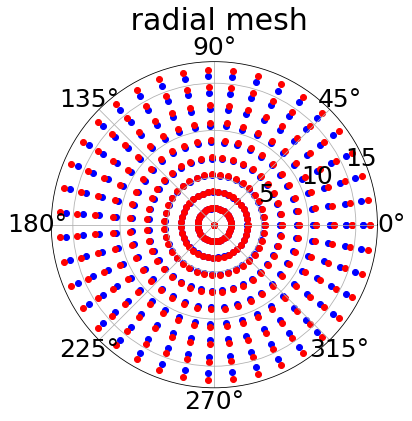

In [435]:
#Generates a radial mesh with variable distance between consecutive rings
def RadialMeshGenerator(pointDis,MeshSize,ratio):
     # number of bins in r and theta dimensions
    N_bins_theta = round(MeshSize/(np.sqrt(2**3)*pointDis))*4
    N_bins_r = round(MeshSize/(np.sqrt(2**3)*pointDis))

    # limits in r dimension
    rmin = 0
    rmax = MeshSize/2

    # setting up 1D arrays in r and theta
    pausur=(rmax)/N_bins_r
    up=pointDis/np.sqrt(2)*ratio
    r=np.zeros(N_bins_r)
    for i in range(N_bins_r):
        r[i]=pausur*i+up*i**2
     
    theta = np.linspace(0, 2*np.pi, N_bins_theta)  # N.B. radians not degrees

    # 'gridding' the 1D arrays into 2D arrays so they can be used by pcolor
    theta, r = np.meshgrid(theta, r)
    return theta,r




#radial equidistant mesh with diverging mesh
thetaeq,req=RadialMeshGenerator(Aactualmesh,35,0)
thetadiv,rdiv=RadialMeshGenerator(Aactualmesh,35,0.01)
ax1=plt.subplot(111,projection="polar")
ax1.set_title(" radial mesh")
ax1.scatter(thetaeq,req,color="blue")
ax2=plt.subplot(111,projection="polar")
ax2.scatter(thetadiv,rdiv,color="red")
#Extract one meridian from equidistant and diverging meshes
rexeq=np.zeros(len(req))
rexdiv=np.zeros(len(rdiv))
for i in range(len(req)):
    rexeq[i]=req[i][0]
for i in range(len(rdiv)):
    rexdiv[i]=rdiv[i][0]

## Finding matching points.

When the device mesh(equidistant mesh) and data(divergent mesh) are superimposed, points that are closer than the distance between real mesh holes (Aactualmesh) will be assumed to correspond to each other, marked as matching and plotted as such

Text(0, 0.5, 'position(mm)')

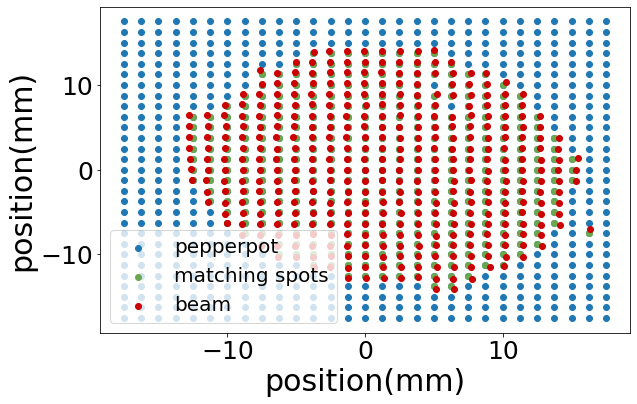

In [436]:
# Define the distance from the mesh and the image. This value is set by 
# pepper physical imlpementation
L = 35 # mm
# Find the mesh and the image related points indices
meshrelation = np.zeros((len(xs),2))
mindistindex = np.zeros((1,2))
for i in range(len(xs)):
    mindist = Amesh
    distcalc = 0
    for j in range(len(xm)):
        distcalc = np.sqrt((xs[i]-xm[j])**2+(ys[i]-ym[j])**2)
        if mindist > distcalc:
            mindistindex [0][0]= i
            mindistindex [0][1]= j
            mindist = distcalc
    meshrelation[i] = mindistindex
# Draw the points and highlight the center.
fig, ax = plt.subplots()
plt.rc('font', size=30) #controls default text size
plt.rc('axes', titlesize=30) #fontsize of the title
plt.rc('axes', labelsize=30) #fontsize of the x and y labels
plt.rc('xtick', labelsize=25) #fontsize of the x tick labels
plt.rc('ytick', labelsize=25) #fontsize of the y tick labels
plt.rc('legend', fontsize=20) #fontsize of the legend
ax.scatter(xm, ym, marker = 'o',label="pepperpot")
for i in range(len(xs)):
    ax.scatter(xm[int(meshrelation[i][1])], ym[int(meshrelation[i][1])], 
               color="#6AA84F")
    #ax.annotate(i, (xs[i], ys[i]))
    #ax.annotate(i, (xm[int(meshrelation[i][1])], ym[int(meshrelation[i][1])]))
ax.scatter(xm[int(meshrelation[i][1])], ym[int(meshrelation[i][1])], 
           color="#6AA84F", label="matching spots") #Repeated last to set legend
ax.scatter(xs,ys,color="#CC0000", label="beam")
ax.legend()
ax.set_xlabel ("position(mm)")
ax.set_ylabel ("position(mm)")

## Emittance calculation by usual method.
we will use the following expression for rms emittance:

$\epsilon_{rms}=\sqrt{<x^{2}><x'^{2}>-<xx'>^{2}}$ 

with

$<x^{2}>=\frac{1}{N}\sum \limits _{i=1} ^{N} (x_{i}-\overline {x})^{2}$ 

$\overline {x} = \frac{1}{N}\sum \limits _{i=1} ^{N} x_{i}$ 

$<xx'>=\frac{1}{N}\sum \limits _{i=1} ^{N} (x_{i}-\overline {x})(x'_{i}-\overline {x'})$ 

In [437]:
# Calculate x' and y'
xsp = np.zeros(len(xs))
ysp = np.zeros(len(ys))
i = 0
for inds in meshrelation:
    #print(xs[int(inds[0])])
    xsp[i] = (xs[int(inds[0])] - xm[int(inds[1])])/L
    ysp[i] = (ys[int(inds[0])] - ym[int(inds[1])])/L
    i = i + 1

xsmean = np.mean(xs) # \overline{x}
xspmean = np.mean(xsp) # \overline{x'}
xs2 = np.mean((xs-xsmean)**2) # <x^{2}>
xsp2 = np.mean((xsp-xspmean)**2) # <x'^{2}>
xsxsp = np.mean((xs-xsmean)*(xsp-xspmean)) # <xx'> 
ysmean = np.mean(ys) 
yspmean = np.mean(ysp)
ys2 = np.mean((ys-ysmean)**2) 
ysp2 = np.mean((ysp-yspmean)**2)
ysysp = np.mean((ys-ysmean)*(ysp-yspmean)) 

exrms = np.sqrt(xs2*xsp2-xsxsp**2)
eyrms = np.sqrt(ys2*ysp2-ysysp**2)

print ("Emittance x rms (mmrad): ", exrms)
print ("Emittance y rms (mmrad): ", eyrms)

print ("Emittance x rms (πmmrad): ", exrms/np.pi)
print ("Emittance y rms (πmmrad): ", eyrms/np.pi)


Emittance x rms (mmrad):  0.009954267618369516
Emittance y rms (mmrad):  0.012286504099979414
Emittance x rms (πmmrad):  0.003168541792646194
Emittance y rms (πmmrad):  0.003910915721661125


# Note: from now on to measure the validity of the FFT method only the generated radial meshes will be used.

## Calculating radial emmitance by usual method.

We can use the previous expression for emmitance in this case too

In [438]:
#Calculate r'
rpex=np.zeros(len(rexdiv))
for j in range(len(rpex)):
    rpex[j]=(rexdiv[j]-rexeq[j])/L
    
#Calculate emittance
rsmean=np.mean(rexdiv)#\overline{r}
rspmean=np.mean(rpex)#\overline{r'}
rs2=np.mean((rexdiv-rsmean)**2)#\<r^2>
rsp2=np.mean((rpex-rspmean)**2)#\<r'^2>
rexdivrp=np.mean((rexdiv-rsmean)*(rpex-rspmean))#\<rr'>
errms=np.sqrt(rs2*rsp2-rexdivrp**2)
print ("Emittance r rms (mmrad): ", errms)
print ("Emittance r rms (πmmrad): ", errms/np.pi)

Emittance r rms (mmrad):  0.009223780407186648
Emittance r rms (πmmrad):  0.0029360204915958605


## Plotting FFT of equidistant and diverging meshes

Plotting the FFT by itself as seen below shows almost no resolution in resulting plot. To inprove this meshes are padded with equal amounts of zeros on the left and on the right(next cell)

### FFT plots with no zeros added

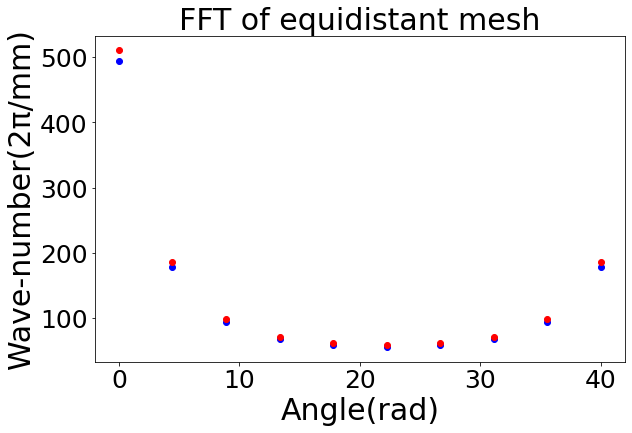

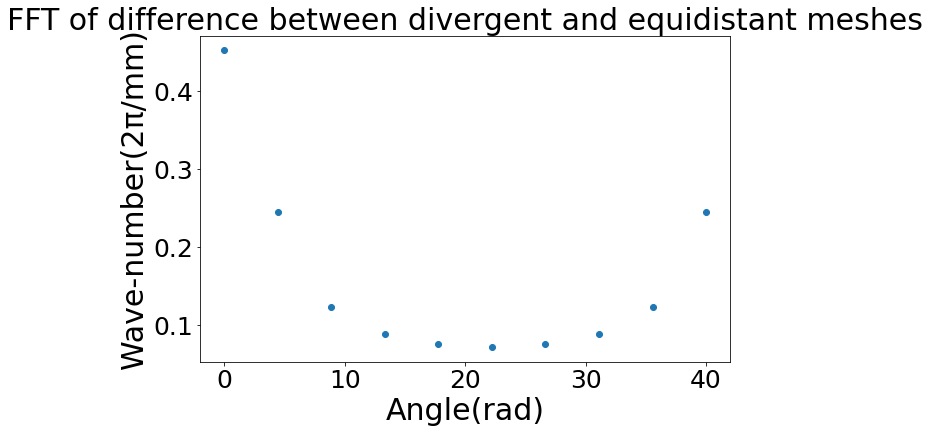

In [439]:
#Padding signal with zeros
zeroak=0
req=np.zeros(len(rexeq)+zeroak)
rp=np.zeros(len(rpex)+zeroak)
rdiv=np.zeros(len(rexdiv)+zeroak)
if(zeroak!=0):
    a=slice(round(zeroak/2),-round(zeroak/2))
    req[a]=rexeq
    rp[a]=rpex
    rdiv[a]=rexdiv
else:
    req=rexeq
    rp=rpex
    rdiv=rexdiv
#FFT of the meshes
reqf=2*np.pi*fft(req)
rpf=2*np.pi*fft(rp)
rdivf=2*np.pi*fft(rdiv)
reqfrek=np.linspace(0,40,len(req))
rpfrek=np.linspace(0,40,len(rp))
rdivfrek=np.linspace(0,40,len(rdiv))
#plots
fig,plot=plt.subplots()
plot.set_xlabel("Angle(rad)")
plot.set_ylabel("Wave-number(2π/mm)")
plot.set_title("FFT of equidistant mesh")
plot.scatter(reqfrek,np.abs(reqf),color="blue")
plot.scatter(rdivfrek,np.abs(rdivf),color="red")
fig1,plot1=plt.subplots()
plot1.set_xlabel("Angle(rad)")
plot1.set_ylabel("Wave-number(2π/mm)")
plot1.set_title("FFT of difference between divergent and equidistant meshes")
plot1.scatter(rpfrek,np.abs(rpf))

### FFT plots with added zeros. Note that the amount of zeros changes the resolution of the image

Equidistant mesh in blue
Diverging mesh in red


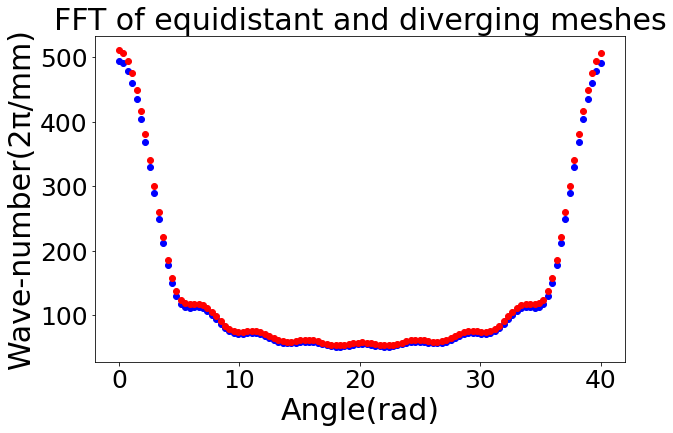

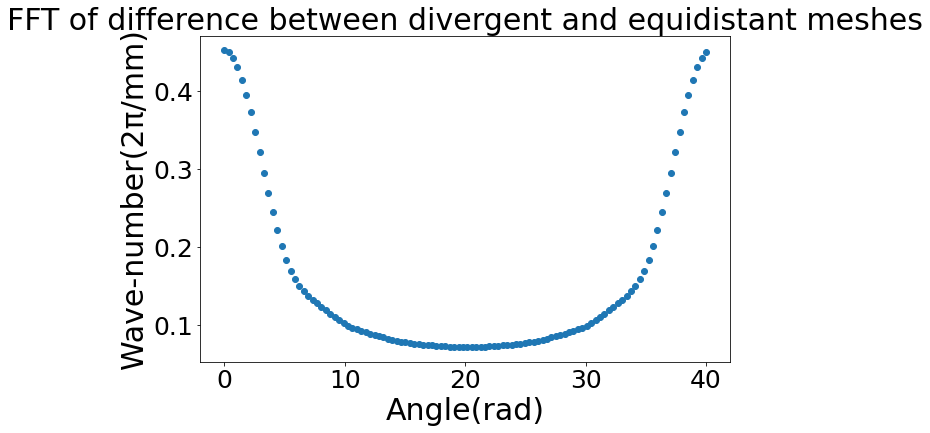

In [440]:
#Padding signal with zeros
zeroak=100
req=np.zeros(len(rexeq)+zeroak)
rp=np.zeros(len(rpex)+zeroak)
rdiv=np.zeros(len(rexdiv)+zeroak)
if(zeroak!=0):
    a=slice(round(zeroak/2),-round(zeroak/2))
    req[a]=rexeq
    rp[a]=rpex
    rdiv[a]=rexdiv
else:
    req=rexeq
    rp=rpex
    rdiv=rexdiv
#FFT of the meshes
reqf=2*np.pi*fft(req)
rpf=2*np.pi*fft(rp)
rdivf=2*np.pi*fft(rdiv)
reqfrek=np.linspace(0,40,len(req))
rpfrek=np.linspace(0,40,len(rp))
rdivfrek=np.linspace(0,40,len(rdiv))
#plots
fig,plot=plt.subplots()
plot.set_xlabel("Angle(rad)")
plot.set_ylabel("Wave-number(2π/mm)")
print("Equidistant mesh in blue")
print("Diverging mesh in red")
plot.set_title("FFT of equidistant and diverging meshes")
plot.scatter(reqfrek,np.abs(reqf),color="blue")
plot.scatter(rdivfrek,np.abs(rdivf),color="red")
fig1,plot1=plt.subplots()
plot1.set_xlabel("Angle(rad)")
plot1.set_ylabel("Wave-number(2π/mm)")
plot1.set_title("FFT of difference between divergent and equidistant meshes")
plot1.scatter(rpfrek,np.abs(rpf))

At this point, in order to calculate emittance utilizing the FFT a phenomenon has been observed: the secondary local maxima height in the FFT plot increase with the amount of divergence of the diverging plot.

Next the correlation between the difference plot and the emittance will be calculated

## Correlation between FFT plot maxima and emittance

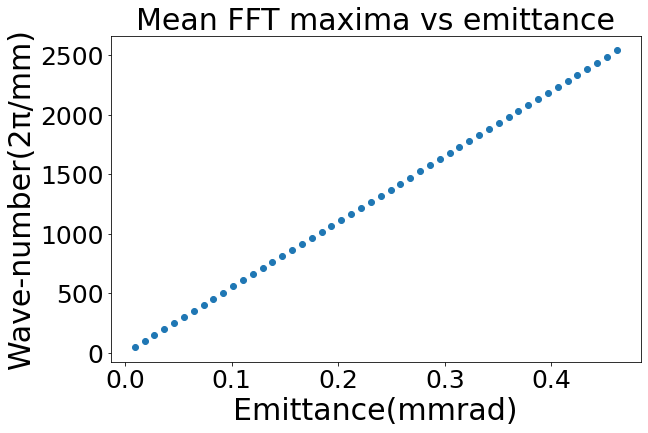

In [441]:
def get_max(rfe,rfd):
    maximoak=[]
    # for local minima
    maxima=argrelextrema(rfd,np.greater)[0]
    dif=0
    for maxi in maxima:
        dif+=np.abs(rfd[maxi]-rfe[maxi])
    return dif

def Emi_Fourier_corr(n,zeroak,show_plot):
    emi=np.zeros(n)
    punta=np.zeros(n)
    for i in range(n):
        #Generate meshes
        thetaeq,req=RadialMeshGenerator(Aactualmesh,35,0)
        thetadiv,rdiv=RadialMeshGenerator(Aactualmesh,35,(i+1)*0.01)
        rexeq=np.zeros(len(req))
        rexdiv=np.zeros(len(rdiv))
        
        #Extract theta=0 meridian from meshes
        for j in range(len(req)):
            rexeq[j]=req[j][0]
        for j in range(len(rdiv)):
            rexdiv[j]=rdiv[j][0]
            
        #Calculate r'
        rp=np.zeros(len(rexdiv))
        for j in range(len(rp)):
            rp[j]=(rexdiv[j]-rexeq[j])/L
            
        #Calculate emittance
        rsmean=np.mean(rexeq)#\overline{r}
        rspmean=np.mean(rp)#\overline{r'}
        rs2=np.mean((rexeq-rsmean)**2)#\<r^2>
        rsp2=np.mean((rp-rspmean)**2)#\<r'^2>
        rexeqrp=np.mean((rexeq-rsmean)*(rp-rspmean))#\<rr'>
        emi[i]=np.sqrt(rs2*rsp2-rexeqrp**2)
        #padding the arrays with selected amount of zeros
        rpex=np.zeros(len(rp)+zeroak)
        reqex=np.zeros(len(rexeq)+zeroak)
        rdivex=np.zeros(len(rexdiv)+zeroak)
        if(np.mod(zeroak,2)!=0):
            zeroak=+1
        a=slice(round(zeroak/2),-round(zeroak/2))
        if(zeroak!=0):
            rpex[a]=rp
            reqex[a]=rexeq
            rdivex[a]=rexdiv
        else:
            rpex=rp
            reqex=rexeq
            rdivex=rexdiv
        #Perform FFT of padded arrays
        rpf=2*np.pi*fft(rpex)
        reqf=2*np.pi*fft(reqex)
        rdivf=2*np.pi*fft(rdivex)
        #Calculate mean maxima of the difference grid
        punta[i]=get_max(reqf,rdivf)
    #plot emittance agains mean maximum height in difference plot
    if(show_plot):
        fig,plot=plt.subplots()
        plot.set_xlabel("Emittance(mmrad)")
        plot.set_ylabel("Wave-number(2π/mm)")
        plot.set_title("Mean FFT maxima vs emittance")
        plot.scatter(emi,punta)
    #Linear regresion of correlation
    punta=np.array(punta).reshape(-1,1)
    model = LinearRegression()
    model.fit(punta/len(rpf),emi)
    b0=model.intercept_
    b1=model.coef_
    return b0,b1
    
    #Retreive linear regresion parameters for DFT and FFT calculations
    return modelff.coef_,modelff.intercept_
b1,b0=Emi_Fourier_corr(50,20,True)

As it seems, emittance and mean FFT maxima are linearly correlated. So if we perform a linear regresion on the previous graph, we can construct a formula to get the emittance in a divergence range around %1 of divergence.

Note that, the slope of the graph changes with the amount of zeros added to grids, since, as I read, padding signals with zeros increases the height of their local maxima. At first, I thought this effect would be negated in the correlation plot  since the values calculated by the get_Max function come from the difference in value of the  diverging and equidistant plots, both padded with the same amount of zeros, but it doesn't seem to be the case. This may be because the local maxima aren't exactly at the same x axis points in Fourier space.

Next, a comparison of the results between regular and FFT method emittances will be made.

## Comparison between regular and FFT method emittances

In [442]:
Aactualmesh=1.25
theta0,r0=RadialMeshGenerator(Aactualmesh,40,0)
theta05,r05=RadialMeshGenerator(Aactualmesh,40,0.01)
re=np.zeros(len(r0))
rd=np.zeros(len(r05))
rp=np.zeros(len(r05))
zeroak=28
#Extracting a single meridian from grid
for j in range(len(r0)):
    re[j]=r0[j][0]
for j in range(len(r05)):
    rd[j]=r05[j][0]
for j in range(len(r05)):
    rp[j]=rd[j]-re[j]
#Padding the arrays with zeros
rpex=np.zeros(len(rp)+zeroak)
reex=np.zeros(len(rd)+zeroak)
rdex=np.zeros(len(re)+zeroak)
if(np.mod(zeroak,2)!=0):
    zeroak=+1
a=slice(round(zeroak/2),-round(zeroak/2))
if(zeroak!=0):
    rpex[a]=rp
    reex[a]=re
    rdex[a]=rd
else:
    rpex=rp
    reex=re
    rdex=rd
#Performing FFT of the arrays
rdf=2*np.pi*fft(rdex)
ref=2*np.pi*fft(reex)
dif=get_max(ref,rdf)
b0ff,b1ff=Emi_Fourier_corr(40,zeroak,False)
emi_fft=(b1ff*dif+b0ff)
#Calculate emittance
remean=np.mean(re)#\overline{r}
rpmean=np.mean(rp)#\overline{r'}
rs2=np.mean((re-remean)**2)#\<r^2>
rsp2=np.mean((rp-rpmean)**2)#\<r'^2>
rex05rp=np.mean((re-remean)*(rp-rpmean))#\<rr'>
emi=np.sqrt(rs2*rsp2-rex05rp**2)
print("Regular method emittance: ",emi)
print("FFT method emittance : ",emi_fft[0])
print("Relative error %",np.abs((emi_fft-emi)/(emi+emi_fft))[0]*100)

Regular method emittance:  0.44882767404844404
FFT method emittance :  0.4428810678919291
Relative error % 0.6668776335617187


As it seems, with a certain amount of padded zeros (28 in the previous code) a pretty good approximation for emittance can be achieved with the FFT method. But again, the emittance we get with the FFT method changes with the amount of zeros added and as it can be seen by replacing the zero amount with 100, drastically so.

In order to negate this, an attempt will be made to make the FFT emittance invariant of the padding zero amount in the following code.

## Analyzing zero amount dependency of FFT method emittance


Offset of the main sinusoidal term 0.07130979422527194
Main sinusoidal frecuency:  [  0 250]
Average of the FFT emittance vs zero amount:  0.05867604999318036


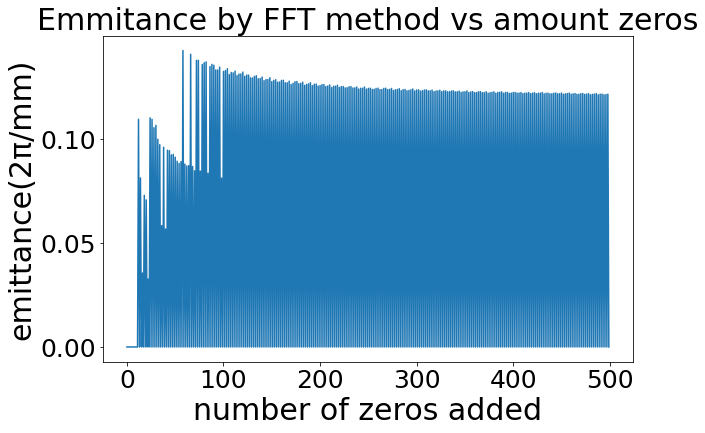

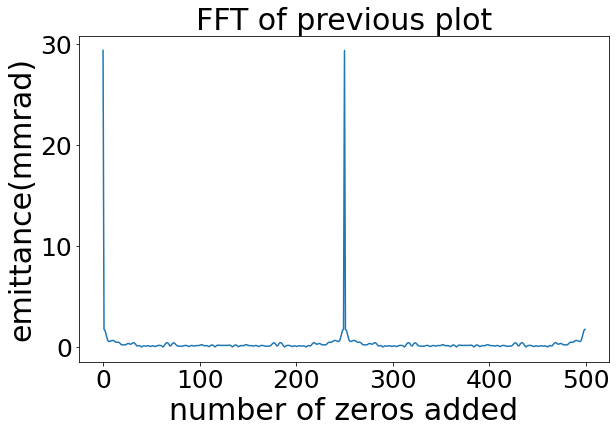

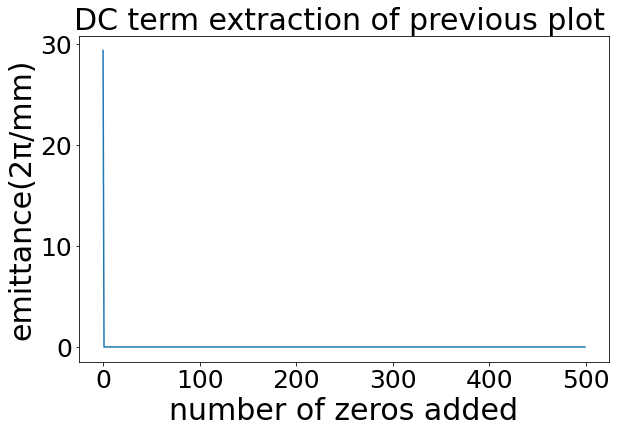

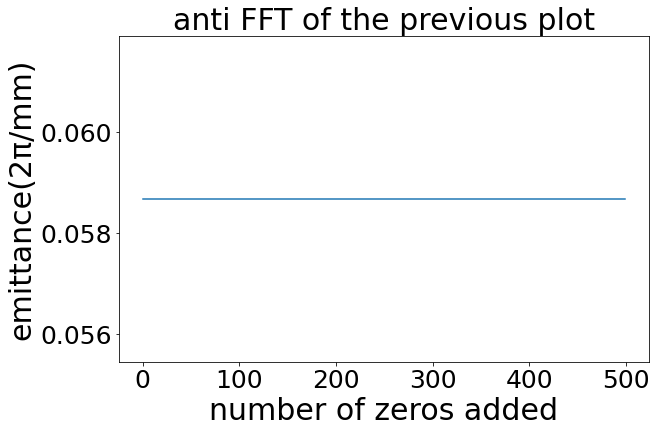

In [443]:
def f(re,rd,n):
    emi_fft=np.zeros(n)
    #mapping FFT emittance for various added zero amounts
    for i in range(2,n,2):
        reex=np.zeros(len(re)+i)
        rdex=np.zeros(len(rd)+i)
        a=slice(int(np.floor(i/2)),-int(np.floor(i/2)))
        if(i!=0):
            reex[a]=re
            rdex[a]=rd
        else:
            reex=re
            rdex=rd
        rdf=(2*np.pi)*fft(rdex)
        ref=(2*np.pi)*fft(reex)
        dif=get_max(np.abs(ref),np.abs(rdf))
        b0,b1=Emi_Fourier_corr(40,i,False)
        emi_fft[i]=(b1*dif+b0)
        emi_fft_fft=fft(emi_fft)
        pasa=np.zeros(len(emi_fft_fft))
        pasa[0]=np.abs(emi_fft_fft[0])
        sinu=ifft(pasa)
    print("Offset of the main sinusoidal term",max(np.abs(emi_fft))/2)
    print("Main sinusoidal frecuency: ",np.where(np.abs(emi_fft_fft)==np.abs(max(emi_fft_fft)))[0])
    fig,plot=plt.subplots()
    plot.set_xlabel("number of zeros added")
    plot.set_ylabel("emittance(2π/mm)")
    plot.set_title("Emmitance by FFT method vs amount zeros")
    plot.plot(range(n),np.abs(emi_fft))
    
    fig3,plot3=plt.subplots()
    plot3.set_xlabel("angle(rad)")
    plot3.set_ylabel("emittance(mmrad)")
    plot3.set_title("FFT of previous plot")
    plot3.plot(range(n),np.abs(emi_fft_fft))
    
    fig1,plot1=plt.subplots()
    plot1.set_xlabel("angle(rad)")
    plot1.set_ylabel("emittance(2π/mm)")
    plot1.set_title("DC term extraction of previous plot ")
    plot1.plot(range(n),np.abs(pasa))
    
    fig2,plot2=plt.subplots()
    plot2.set_xlabel("number of zeros added")
    plot2.set_ylabel("emittance(2π/mm)")
    plot2.set_title("anti FFT of the previous plot")
    plot2.plot(range(n),np.abs(sinu))
    print("Average of the FFT emittance vs zero amount: ",np.abs(sum(emi_fft)/len(emi_fft)))
    

f(re,rd,n=500)

So, the previous plots show how with enough zeros added the FFT emmitance behaves like an almost pure sinusoidal function with amplitude 0.0587(mmrad) offset by 0.0713(mmrad) and oscilating at frecuency 2π*250 (rad/s).

Next I am going to attempt recalculating FFT emittance with around 500 zeroes and divide this sinusoidal function to it.

## Regular and FFT method emittance comparison with corrected zero dependency

In [444]:
theta0,r0=RadialMeshGenerator(Aactualmesh,40,0)
theta05,r05=RadialMeshGenerator(Aactualmesh,40,0.01)
re=np.zeros(len(r0))
rd=np.zeros(len(r05))
rp=np.zeros(len(r05))
zeroak=500
#Extracting a single meridian from grid
for j in range(len(r0)):
    re[j]=r0[j][0]
for j in range(len(r05)):
    rd[j]=r05[j][0]
for j in range(len(r05)):
    rp[j]=rd[j]-re[j]
#Padding the arrays with zeros
rpex=np.zeros(len(rp)+zeroak)
reex=np.zeros(len(rd)+zeroak)
rdex=np.zeros(len(re)+zeroak)
if(np.mod(zeroak,2)!=0):
    zeroak=+1
a=slice(round(zeroak/2),-round(zeroak/2))
if(zeroak!=0):
    rpex[a]=rp
    reex[a]=re
    rdex[a]=rd
else:
    rpex=rp
    reex=re
    rdex=rd
#Performing FFT of the arrays
rdf=2*np.pi*fft(rdex)
ref=2*np.pi*fft(reex)
dif=get_max(ref,rdf)
b0ff,b1ff=Emi_Fourier_corr(40,zeroak,False)
emi_fft=(b1ff*dif+b0ff)/(0.587*np.sin(250*zeroak)+0.0713)
#Calculate emittance
remean=np.mean(re)#\overline{r}
rpmean=np.mean(rp)#\overline{r'}
rs2=np.mean((re-remean)**2)#\<r^2>
rsp2=np.mean((rp-rpmean)**2)#\<r'^2>
rex05rp=np.mean((re-remean)*(rp-rpmean))#\<rr'>
emi=np.sqrt(rs2*rsp2-rex05rp**2)
print("Regular method emittance: ",emi)
print("zero dependency corrected FFT method emittance : ",emi_fft[0])
print("Relative error %",np.abs((emi_fft-emi)/(emi+emi_fft))[0]*100)

Regular method emittance:  0.44882767404844404
zero dependency corrected FFT method emittance :  11.725824969971342
Relative error % 92.62685043800558


The correction method not only has greatly increased the discrepancy between the two emittance calculations but it has also failed to remove the zero amount dependency from the FFT method emittance. More work has to be done.

## Recalculating emittance with random divergin grid points extracted

Lastly, for the purpose of trying to simulate a more real scenario for the FFT emittance calculation the comparison between the two methods will be performed again but with random points from the grid missing. %10 of the points from the diverging grid will be randomly removed and then the emittances will be calculated again. Because this process includes randomness, the recalculations will be performed 500 times and the mean relative error achieved.

In [445]:
def erroreak(rp,re,rdf,ref):
    if(len(rp)*0.1<1):
        print("Unable too remove points: too little points in input arrays")
        sys.exit()
    else:
        for i in range(round(len(rp)*0.01)):
            rp[random.choice(range(len(rp)))]=0
            rdf[random.choice(range(len(rdf)))]=0
    remean=np.mean(re)#\overline{r}
    rpmean=np.mean(rp)#\overline{r'}
    rs2=np.mean((re-remean)**2)#\<r^2>
    rsp2=np.mean((rp-rpmean)**2)#\<r'^2>
    rex05rp=np.mean((re-remean)*(rp-rpmean))#\<rr'>
    emi=np.sqrt(rs2*rsp2-rex05rp**2)
    dif=get_max(np.abs(ref),np.abs(rdf))
    b0,b1=Emi_Fourier_corr(40,zeroak,False)
    emi_fft=(b1*dif+b0)
    errore=2*np.abs((emi_fft-emi)/(emi+emi_fft))[0]*100
    #print("Metodo arruntarekin lorturiko emitantzia: ",emi)
    #print("FFT-aren bidez lortutako emitantzia: ",emi_fft[0])
    return errore
errore=np.zeros(500)
for n in range(500):
    errore[n]=erroreak(rp,re,rdf,ref)
print("Relative error: %",sum(errore)/100)

Relative error: % 573.5015535388001


As it can be seen removing points decreases the quality of this FFT method, this will try to be solved in the future.